<a href="https://colab.research.google.com/github/diego-mogollon/lateguru/blob/conor-data-modelling/Lateguru_Modelling_C_NN_RFB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries & Datasets**

This notebook models flight delays using binary classification with two models:
- A dense neural network with a sigmoid activation function
- A Bagged Classifier of Random Forest Base Models

In [1]:
#importing python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy import stats

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA

#import xgboost as xgb

#from imblearn.over_sampling import SMOTE, ADASYN


In [2]:
from google.colab import drive


# Mount your Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [26]:


# Specify the path to your CSV file (replace with your actual path)
X_test_preprocessed = '/content/drive/MyDrive/Lateguru/data/X_test_preprocessed_dt.csv'
X_train_preprocessed = '/content/drive/MyDrive/Lateguru/data/X_train_preprocessed_dt.csv'
y_test_sample = '/content/drive/MyDrive/Lateguru/data/y_test_sample_dt.csv'
y_train_sample = '/content/drive/MyDrive/Lateguru/data/y_train_sample_dt.csv'

# Specify the path to your CSV file (replace with your actual path)
# - Lighter csvs with smaller dimensionality
'''X_test_preprocessed_lite = '/content/drive/MyDrive/Lateguru/data/X_test_preprocessed_dt_lite.csv'
X_train_preprocessed_lite = '/content/drive/MyDrive/Lateguru/data/X_train_balanced_dt_lite.csv'
y_test_sample_lite = '/content/drive/MyDrive/Lateguru/data/y_test_sample_dt_lite.csv'
y_train_sample_lite = '/content/drive/MyDrive/Lateguru/data/y_train_balanced_dt_lite.csv'''

'''# Read the CSV file into a Pandas DataFrame
X_test_preprocessed_df = pd.read_csv(X_test_preprocessed, compression='zip')
X_train_preprocessed_df = pd.read_csv(X_train_preprocessed,compression='zip')
y_test_sample_df = pd.read_csv(y_test_sample, compression='zip')
y_train_sample_df = pd.read_csv(y_train_sample, compression='zip')'''

# Read the CSV file into a Pandas DataFrame
X_test_preprocessed_df = pd.read_csv(X_test_preprocessed, compression='zip')
X_train_preprocessed_df = pd.read_csv(X_train_preprocessed,compression='zip')
y_test_sample_df = pd.read_csv(y_test_sample, compression='zip')
y_train_sample_df = pd.read_csv(y_train_sample, compression='zip')

# Print the first few rows of the DataFrame
print(X_test_preprocessed_df.head(1))
print(X_train_preprocessed_df.head(1))
print(y_test_sample_df.head(1))
print(y_train_sample_df.head(1))

     0    1    2    3    4    5    6    7    8    9  ...       411       412  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.343952 -0.392953   

        413       414       415     416       417       418       419  \
0  0.418822 -1.065777 -0.428486 -0.1986 -0.010991 -1.336718  1.011177   

        420  
0  0.098363  

[1 rows x 421 columns]
     0    1    2    3    4    5    6    7    8    9  ...       411       412  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.398641 -0.497578   

        413       414      415     416       417       418       419       420  
0  0.418822 -1.065777 -0.62108 -0.1986 -0.010991 -0.143549  0.010834  1.555977  

[1 rows x 421 columns]
   Delayed
0    False
   Delayed
0     True


In [4]:
y_test_sample_df.value_counts(normalize=True)

,proportion
Delayed,
False,0.610721
True,0.389279


In [5]:
y_train_sample_df.value_counts(normalize=True)

,proportion
Delayed,
False,0.61072
True,0.38928


In [27]:
y_test_sample_df['Delayed'] = y_test_sample_df['Delayed'].apply(lambda x: 1 if x == True else 0)
y_train_sample_df['Delayed'] = y_train_sample_df['Delayed'].apply(lambda x: 1 if x == True else 0)

In [28]:
#Using principal component analysis to reduce dimensionality
pca = PCA(n_components=7)
X_train_preprocessed_df = pca.fit_transform(X_train_preprocessed_df)
X_test_preprocessed_df = pca.transform(X_test_preprocessed_df)


In [29]:
X_test_preprocessed_arr = np.array(X_test_preprocessed_df)
X_train_preprocessed_arr = np.array(X_train_preprocessed_df)
y_test_sample_arr = np.array(y_test_sample_df)
y_train_sample_arr = np.array(y_train_sample_df)


In [30]:
print(f"X_test_preprocessed shape: {X_test_preprocessed_arr.shape}")
print(f"X_train_preprocessed shape: {X_train_preprocessed_arr.shape}")
print(f"y_test_sample shape: {y_test_sample_arr.shape}")
print(f"y_train_sample shape: {y_train_sample_arr.shape}")


X_test_preprocessed shape: (302891, 7)
X_train_preprocessed shape: (1211560, 7)
y_test_sample shape: (302891, 1)
y_train_sample shape: (1211560, 1)


In [31]:
y_train_sample_arr = y_train_sample_arr.reshape(-1)
#only needed with SVM, uncomment for NN


In [18]:
#splitting the test data into a validation set to ensure no data leakage during nn training
#make sure to evaluate the model on X_test_sample_nn

X_val, X_test_sample_nn, y_val, y_test_sample_nn = train_test_split(X_test_preprocessed_arr, y_test_sample_arr,
                 test_size=0.5,
                 random_state=42,
                 stratify=y_test_sample_arr)

In [10]:
pd.DataFrame(y_val).value_counts(normalize=True)

NameError: name 'y_val' is not defined

In [45]:
pd.DataFrame(y_test_sample_nn).value_counts(normalize=True)

,proportion
0,
0,0.610719
1,0.389281


In [21]:
print(f"X_val shape: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test_sample_nn shape: {X_test_sample_nn.shape}")
print(f"y_test_sample_nn: {y_test_sample_nn.shape}")

X_val shape: (151445, 414)
y_val: (151445, 1)
X_test_sample_nn shape: (151446, 414)
y_test_sample_nn: (151446, 1)


 #  **Modelling with a SVM Classifier**

In [8]:
from sklearn.svm import SVC
from sklearn.metrics import recall_score, roc_auc_score, accuracy_score, f1_score, confusion_matrix



In [9]:
sig_svm_clf = SVC(kernel='rbf')

In [ ]:
sig_svm_clf.fit(X_train_preprocessed_arr, y_train_sample_arr)

In [ ]:
y_pred = sig_svm_clf.predict(X_test_preprocessed)

In [ ]:
recall = recall_score(y_test_sample, y_pred)
print(f"Recall: {recall}")

f1 = f1_score(y_test_sample, y_pred)
print(f"F1 score: {f1}")

# **Modelling with a Dense Neural Network**

In [22]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop


# Assuming you have your input data prepared


model = Sequential()
model.add(layers.Dense(256,activation='tanh', input_dim=X_train_preprocessed_arr.shape[1]))
model.add(layers.Dense(128,activation='tanh'))
#model.add(layers.Dense(128,activation='relu'))
#model.add(layers.Dense(128,activation='tanh'))
model.add(layers.Dense(64,activation='tanh'))
model.add(layers.Dense(32,activation='tanh')) #regularise some layers, try tanh a bit
#model.add(layers.Dense(16,activation='tanh'))
model.add(layers.Dense(8,activation='tanh'))
model.add(layers.Dense(1,activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         106,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 149,745 (584.94 KB)

 Trainable params: 149,745 (584.94 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
adam = Adam(
    learning_rate=0.001
)

RMSprop = RMSprop(
    learning_rate=0.001
)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', 'recall', 'precision', 'f1_score'])


#optimise learning rates by splitting out adam

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=20, restore_best_weights=True)

In [115]:
#Need to manually define a balanced validation set

In [26]:
history = model.fit(X_train_preprocessed_arr, y_train_sample_arr, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks =[es])

Epoch 1/10
37862/37862 ━━━━━━━━━━━━━━━━━━━━ 84s 2ms/step - accuracy: 0.7868 - f1_score: 0.5607 - loss: 0.4586 - precision: 0.8981 - recall: 0.5106 - val_accuracy: 0.7932 - val_f1_score: 0.5604 - val_loss: 0.4459 - val_precision: 0.9073 - val_recall: 0.5220
Epoch 2/10
37862/37862 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step - accuracy: 0.7916 - f1_score: 0.5607 - loss: 0.4463 - precision: 0.9028 - recall: 0.5211 - val_accuracy: 0.7918 - val_f1_score: 0.5604 - val_loss: 0.4436 - val_precision: 0.9457 - val_recall: 0.4935
Epoch 3/10
37862/37862 ━━━━━━━━━━━━━━━━━━━━ 74s 2ms/step - accuracy: 0.7926 - f1_score: 0.5605 - loss: 0.4439 - precision: 0.9003 - recall: 0.5257 - val_accuracy: 0.7934 - val_f1_score: 0.5604 - val_loss: 0.4426 - val_precision: 0.8727 - val_recall: 0.5493
Epoch 4/10
37862/37862 ━━━━━━━━━━━━━━━━━━━━ 74s 2ms/step - accuracy: 0.7932 - f1_score: 0.5606 - loss: 0.4425 - precision: 0.8984 - recall: 0.5288 - val_accuracy: 0.7944 - val_f1_score: 0.5604 - val_loss: 0.4413 - val_precision: 

In [27]:
history.history

{'accuracy': [0.7897487282752991,
  0.7922958731651306,
  0.7931352853775024,
  0.7935141324996948,
  0.7936676740646362,
  0.7941100597381592,
  0.7941464185714722,
  0.7945359945297241,
  0.7946746349334717,
  0.7949965596199036],
 'f1_score': [0.5604052543640137,
  0.5604052543640137,
  0.5604052543640137,
  0.5604052543640137,
  0.5604052543640137,
  0.5604052543640137,
  0.5604052543640137,
  0.5604052543640137,
  0.5604052543640137,
  0.5604052543640137],
 'loss': [0.45186659693717957,
  0.4452356994152069,
  0.4434267580509186,
  0.4420732259750366,
  0.44127267599105835,
  0.44049975275993347,
  0.43989261984825134,
  0.4394705891609192,
  0.4394010603427887,
  0.4386238157749176],
 'precision': [0.8998525142669678,
  0.899644672870636,
  0.9010681509971619,
  0.9000093936920166,
  0.9004119038581848,
  0.8939615488052368,
  0.892652690410614,
  0.8922944664955139,
  0.8899663090705872,
  0.8969187140464783],
 'recall': [0.5174902081489563,
  0.5250044465065002,
  0.52639108896

In [28]:
loss, accuracy, recall, precision, f1_score = model.evaluate(X_test_sample_nn, y_test_sample_nn)

print(f"Test loss:{loss}")
print(f"Test recall:{recall}")
print(f"Test accuracy:{accuracy}")
print(f"Test precision:{precision}")
print(f"Test f1 score:{f1_score}")

4733/4733 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7934 - f1_score: 0.5623 - loss: 0.4415 - precision: 0.8782 - recall: 0.5477
Test loss:0.44103559851646423
Test recall:0.5455856323242188
Test accuracy:0.7933850884437561
Test precision:0.8772432208061218
Test f1 score:0.5604060292243958


In [29]:
y_pred = model.predict(X_test_sample_nn)

4733/4733 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


In [30]:
y_test_sample_nn

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [31]:
y_test_sample_nn

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [32]:
y_pred

array([[0.99934715],
       [0.22829515],
       [0.9994399 ],
       ...,
       [0.9994837 ],
       [0.3719132 ],
       [0.14613904]], dtype=float32)

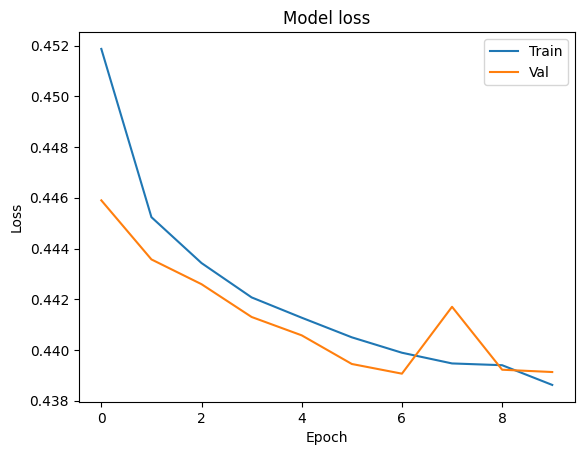

In [33]:
#visualise  graph for overfitting using history

import matplotlib.pyplot as plt

# Assuming you have a history object from model.fit()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.show()




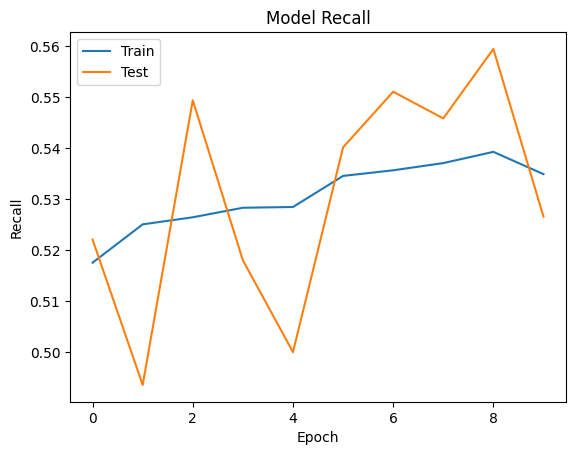

In [34]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# **Bagged Random Forest Model**

In [32]:
# Create base Random Forest model
base_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create bagged ensemble
bagged_model = BaggingClassifier(estimator=base_model, n_estimators=10, random_state=42)

In [ ]:
# Fit the model
bagged_model.fit(X_train_preprocessed_arr, y_train_sample_arr)



In [18]:
# Make predictions
y_pred = bagged_model.predict(X_test_preprocessed_arr)

In [ ]:
y_pred

In [ ]:
y_test_sample_arr = y_test_sample_arr.reshape(-1)

In [19]:
from sklearn.metrics import recall_score, roc_auc_score, accuracy_score, f1_score, confusion_matrix, precision_score, precision_recall_curve

recall = recall_score(y_test_sample_arr, y_pred)
print(f"Recall: {recall}")

f1 = f1_score(y_test_sample_arr, y_pred)
print(f"F1 score: {f1}")

roc_auc = roc_auc_score(y_test_sample_arr, y_pred)
print(f"Roc-auc score: {roc_auc}")

accuracy = accuracy_score(y_test_sample_arr, y_pred)
print(f"accuracy score: {accuracy}")

precision = precision_score(y_test_sample_arr, y_pred)
print(f"precision score: {precision}")

Recall: 0.43402963302207637
F1 score: 0.505264820729522
Roc-auc score: 0.6265033072831132
accuracy score: 0.6691251968529933
precision score: 0.6044742623609175


In [20]:
cm = confusion_matrix(y_test_sample_arr, y_pred)
print(f"Confusion Matrix:\n{cm}")

Confusion Matrix:
[[151496  33486]
 [ 66733  51176]]


In [21]:
from sklearn.metrics import classification_report
report = classification_report(y_test_sample_arr, y_pred)
print(f"Classification Report:\n{report}")

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.82      0.75    184982
           1       0.60      0.43      0.51    117909

    accuracy                           0.67    302891
   macro avg       0.65      0.63      0.63    302891
weighted avg       0.66      0.67      0.66    302891



In [22]:
precision, recall, thresholds = precision_recall_curve(y_test_sample_arr, y_pred)

In [23]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test_sample_arr, y_pred)

In [24]:
average_precision

0.4826799234510911

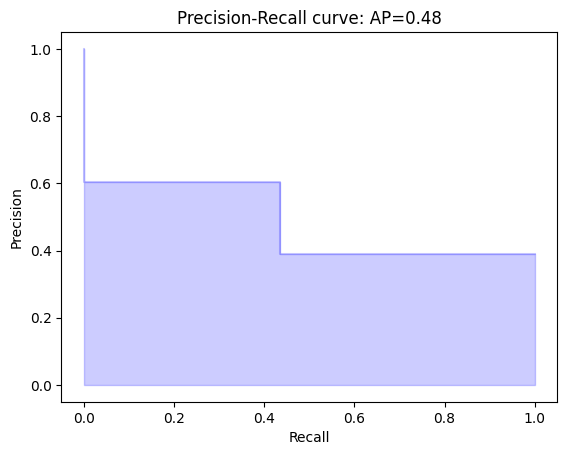

In [25]:
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.ylim([0.0, 1.05])
#plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))


plt.show()